In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve

from sklearn.externals import joblib
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler,SMOTE

from random import random

import matplotlib.pyplot as plt
%matplotlib inline

nrow = 80000
number_of_time = 10

In [20]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [21]:
y = pd.DataFrame(train['target'])
#sc = MinMaxScaler()
x = pd.DataFrame(train.drop('target',axis=1),columns=train.columns[1:])

In [22]:
def data_augmentation(x,y,low_class_ratio = 0.2,method = 'none'):
    if method == 'random_under_sample':
        sm = RandomUnderSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'random_over_sample':
        sm = RandomOverSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'smote':
        sm = SMOTE(sampling_strategy=1-low_class_ratio,m_neighbors=10,kind='svm')
        aug_x,aug_y = sm.fit_resample(x,y)
    else:
        aug_x = x
        aug_y = y
    
    return(pd.DataFrame(aug_x,columns=x.columns),pd.DataFrame(aug_y,columns=['target']))

In [23]:
#test = pd.read_csv('../data/test.csv')
#sub = pd.DataFrame()
#sub['ID_code'] = test['ID_code']
#test.drop('ID_code',axis=1,inplace=True)
train,test = train_test_split(train,test_size = 0.3)

In [24]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)

In [25]:
#predict and combine
def models_list_predict(models,test_x):
    res = np.zeros((test.shape[0]))
    for model in models:
        res = res + model.predict(test_x)
    res = res/len(models)
    return(res)

def combine_pred(x,y,test_x):
    pred = np.zeros((test.shape[0]))
    for i in range(number_of_time):
        model = k_fold_train(x,y,'none',random()/2)
        pred = pred + model.predict(test_x)

    pred = pred/number_of_time
    return(pred)

In [26]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1
}
def k_fold_train(x,y,sample_method = 'none',sample_ratio = 0.2):
    kf = StratifiedKFold(n_splits=3,shuffle=True)
    models = []
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        n_x,n_y = data_augmentation(train_model_x,train_model_y,method=sample_method,low_class_ratio=sample_ratio)
        train_data = lgb.Dataset(n_x,n_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(param,train_set=train_data,num_boost_round=100000,verbose_eval = 100,
                          early_stopping_rounds=1000,valid_sets = [train_data,val_data])
        models.append(model)
    return(models)

In [27]:
base_line = k_fold_train(train_x,train_y)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.891562	valid_1's auc: 0.832989
[200]	training's auc: 0.908753	valid_1's auc: 0.853263
[300]	training's auc: 0.915112	valid_1's auc: 0.858845
[400]	training's auc: 0.919543	valid_1's auc: 0.861519
[500]	training's auc: 0.922564	valid_1's auc: 0.863708
[600]	training's auc: 0.924118	valid_1's auc: 0.865897
[700]	training's auc: 0.925878	valid_1's auc: 0.86684
[800]	training's auc: 0.927269	valid_1's auc: 0.868584
[900]	training's auc: 0.9272	valid_1's auc: 0.867916
[1000]	training's auc: 0.928342	valid_1's auc: 0.869304
[1100]	training's auc: 0.929731	valid_1's auc: 0.869924
[1200]	training's auc: 0.930776	valid_1's auc: 0.871138
[1300]	training's auc: 0.931416	valid_1's auc: 0.871884
[1400]	training's auc: 0.931992	valid_1's auc: 0.871868
[1500]	training's auc: 0.932564	valid_1's auc: 0.872729
[1600]	training's auc: 0.933415	valid_1's auc: 0.873297
[1700]	training's auc: 0.934372	valid_1's auc: 0.873

KeyboardInterrupt: 

In [ ]:
#random_under = k_fold_train(train_x,train_y,'random_under_sample')

In [11]:
random_over = k_fold_train(train_x,train_y,'random_over_sample')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.980559	valid_1's auc: 0.789959
[200]	training's auc: 0.988416	valid_1's auc: 0.82015
[300]	training's auc: 0.990631	valid_1's auc: 0.828591
[400]	training's auc: 0.991643	valid_1's auc: 0.836061
[500]	training's auc: 0.992345	valid_1's auc: 0.840488
[600]	training's auc: 0.992796	valid_1's auc: 0.84424
[700]	training's auc: 0.993616	valid_1's auc: 0.846051
[800]	training's auc: 0.994294	valid_1's auc: 0.84687
[900]	training's auc: 0.994791	valid_1's auc: 0.847318
[1000]	training's auc: 0.995341	valid_1's auc: 0.85075
[1100]	training's auc: 0.995802	valid_1's auc: 0.850622
[1200]	training's auc: 0.996279	valid_1's auc: 0.850906
[1300]	training's auc: 0.996489	valid_1's auc: 0.850992
[1400]	training's auc: 0.996699	valid_1's auc: 0.850415
[1500]	training's auc: 0.996918	valid_1's auc: 0.848893
[1600]	training's auc: 0.997121	valid_1's auc: 0.848518
[1700]	training's auc: 0.997319	valid_1's auc: 0.8486

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.978347	valid_1's auc: 0.804166
[200]	training's auc: 0.989053	valid_1's auc: 0.829347
[300]	training's auc: 0.991399	valid_1's auc: 0.834255
[400]	training's auc: 0.992432	valid_1's auc: 0.836523
[500]	training's auc: 0.993521	valid_1's auc: 0.839581
[600]	training's auc: 0.994114	valid_1's auc: 0.841294
[700]	training's auc: 0.994795	valid_1's auc: 0.843663
[800]	training's auc: 0.995204	valid_1's auc: 0.843636
[900]	training's auc: 0.995479	valid_1's auc: 0.844403
[1000]	training's auc: 0.995891	valid_1's auc: 0.847871
[1100]	training's auc: 0.996186	valid_1's auc: 0.849213
[1200]	training's auc: 0.996501	valid_1's auc: 0.849658
[1300]	training's auc: 0.996736	valid_1's auc: 0.850053
[1400]	training's auc: 0.996769	valid_1's auc: 0.850153
[1500]	training's auc: 0.997062	valid_1's auc: 0.851125
[1600]	training's auc: 0.997238	valid_1's auc: 0.85144
[1700]	training's auc: 0.997391	valid_1's auc: 0.8

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.978246	valid_1's auc: 0.80631
[200]	training's auc: 0.986373	valid_1's auc: 0.832478
[300]	training's auc: 0.98901	valid_1's auc: 0.840439
[400]	training's auc: 0.990584	valid_1's auc: 0.844272
[500]	training's auc: 0.991665	valid_1's auc: 0.849552
[600]	training's auc: 0.992447	valid_1's auc: 0.85394
[700]	training's auc: 0.993378	valid_1's auc: 0.857567
[800]	training's auc: 0.99394	valid_1's auc: 0.858833
[900]	training's auc: 0.994001	valid_1's auc: 0.86094
[1000]	training's auc: 0.994391	valid_1's auc: 0.862319
[1100]	training's auc: 0.994888	valid_1's auc: 0.862566
[1200]	training's auc: 0.995321	valid_1's auc: 0.863582
[1300]	training's auc: 0.995678	valid_1's auc: 0.864005
[1400]	training's auc: 0.995791	valid_1's auc: 0.86439
[1500]	training's auc: 0.996117	valid_1's auc: 0.864057
[1600]	training's auc: 0.99636	valid_1's auc: 0.864451
[1700]	training's auc: 0.996588	valid_1's auc: 0.864215


In [18]:
smote = k_fold_train(train_x,train_y,'smote')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.948115	valid_1's auc: 0.669083
[200]	training's auc: 0.958149	valid_1's auc: 0.697361
[300]	training's auc: 0.96196	valid_1's auc: 0.703603
[400]	training's auc: 0.963923	valid_1's auc: 0.700569
[500]	training's auc: 0.965633	valid_1's auc: 0.70222
[600]	training's auc: 0.967038	valid_1's auc: 0.701059
[700]	training's auc: 0.968068	valid_1's auc: 0.701145
[800]	training's auc: 0.969653	valid_1's auc: 0.700848
[900]	training's auc: 0.970153	valid_1's auc: 0.700833
[1000]	training's auc: 0.970677	valid_1's auc: 0.703039
[1100]	training's auc: 0.971247	valid_1's auc: 0.704661
[1200]	training's auc: 0.972212	valid_1's auc: 0.706602
[1300]	training's auc: 0.972979	valid_1's auc: 0.707559
[1400]	training's auc: 0.973658	valid_1's auc: 0.709261
[1500]	training's auc: 0.974412	valid_1's auc: 0.70923
[1600]	training's auc: 0.975047	valid_1's auc: 0.709092
[1700]	training's auc: 0.975497	valid_1's auc: 0.709

KeyboardInterrupt: 

In [12]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [15]:
pred = models_list_predict(base_line,test.drop('target',axis=1))

result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = pred

In [16]:
#pred = random_under.predict(test.drop('target',axis=1))
#result_df['random_under'] = pred

pred = models_list_predict(random_over,test.drop('target',axis=1))
result_df['random_over'] = pred

pred = models_list_predict(smote,test.drop('target',axis=1))
result_df['smote'] = pred

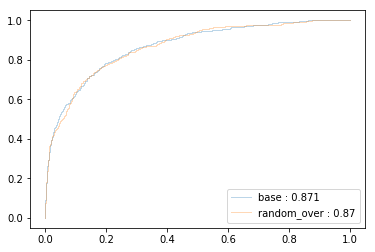

,models,auc_score
0,base,0.871098
1,random_over,0.869940


In [17]:
plotGraph(result_df)

In [13]:
#final_pred = combine_pred(x,y,test)
final_pred = base_line.predict(test)

In [14]:
sub['target'] = final_pred
sub.to_csv("../data/one_round_base_sub.csv",index=False)

In [15]:
final_pred

array([0.13625695, 0.26293197, 0.18565381, ..., 0.00538264, 0.0696702 ,
       0.06835998])